# Toxic Comment Classification Benchmarks
Collection of Deep Learning Text Classification Models and Benchmarks; All gpu models contained within the repo were trained with 4 v100's using the AWS p3.8xlarge instance and the AWS deep learning AMI. 

In [1]:
from IPython.display import Image # display images
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# import model utils
from models.utils import RocAucEvaluation
from models.utils import tok_embed

# sklearn
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


## Table of Contents
1. [Competition Overview](#Competition-Overview)
    1. [Description](#Description)
    2. [Evaluation](#Evaluation)
    3. [Data-Overview](#Data-Overview)
2. [Hardware Used](#Hardware-Used)
3. [Load Data](#Load-Data)
4. [Embeddings](#Embeddings)
5. [Models](#Models)
<br>
<br>
<br>

## Competition Overview
Discussing things you care about can be difficult. The threat of abuse and harassment online means that many people stop expressing themselves and give up on seeking different opinions. Platforms struggle to effectively facilitate conversations, leading many communities to limit or completely shut down user comments. The Kaggle Toxic Comment Classification Challenge sponsored by the Conversation AI team sets out to discover and apply machine learning to identify toxic comments. This (potentially) will allow platforms to identify toxic comments and to successfully fascilitate discussions at scale.
<br>
<br>
<br>
### Description
The Conversation AI team, a research initiative founded by Jigsaw and Google (both a part of Alphabet) are working on tools to help improve online conversation. One area of focus is the study of negative online behaviors, like toxic comments (i.e. comments that are rude, disrespectful or otherwise likely to make someone leave a discussion). So far they’ve built a range of publicly available models served through the Perspective API, including toxicity. But the current models still make errors, and they don’t allow users to select which types of toxicity they’re interested in finding (e.g. some platforms may be fine with profanity, but not with other types of toxic content).
<br>
<br>
In this competition, you’re challenged to build a multi-headed model that’s capable of detecting different types of of toxicity like threats, obscenity, insults, and identity-based hate better than Perspective’s current models. You’ll be using a dataset of comments from Wikipedia’s talk page edits. Improvements to the current model will hopefully help online discussion become more productive and respectful.
<br>
<br>
***Disclaimer: the dataset for this competition contains text that may be considered profane, vulgar, or offensive.***
<br>
<br>
<br>
### Evalution
We randomly select 10% of the training data as the development set. The evaluation metric is the mean column-wise ROC AUC. In other words, the score is the average of the individual AUCs of each predicted column.
<br>
<br>
<br>
### Data Overview
You are provided with a large number of Wikipedia comments which have been labeled by human raters for toxic behavior. The types of toxicity are:
- toxic
- severe_toxic
- obscene
- threat
- insult
- identity_hate

We must create a model which predicts a probability of each type of toxicity for each comment.
<br>
<br>

File descriptions:
- train.csv - the training set, contains comments with their binary labels
- test.csv - the test set, you must predict the toxicity probabilities for these comments. To deter hand labeling, the test set contains some comments which are not included in scoring.
<br>
<br>

***Source: Toxic Comment Classification Challenge, https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/***
<br>
<br>
<br>

## Hardware Used
These models were trained on the amazon p3.8xlarge instance type and a deep learning AMI

### p3.8xlarge

| Instance Size | GPUs - Tesla V100 | GPU Peer to Peer | GPU Memory (GB) | vCPUs | Memory (GB) | Network Bandwidth | EBS Bandwidth | On-Demand Price/hr* | 1-yr Reserved Instance Effective Hourly* | 3-yr Reserved Instance Effective Hourly* |
|---------------|-------------------|------------------|-----------------|-------|-------------|-------------------|---------------|---------------------|------------------------------------------|------------------------------------------|
| p3.8xlarge    | 4                 | NVLink           | 64              | 32    | 244         | 10 Gbps           |  7 Gbps        | 12.24 USD             | 7.96 USD                                  | 9.87 USD                               |

https://aws.amazon.com/ec2/instance-types/p3/
<br>
<br>
<br>
## Load Data

In [2]:
# GLOBE PATHS
TRAIN_FILE = '../data/train.csv'
TEST_FILE = '../data/test.csv'
EMBEDDING_FILE = '../data/glove.42B.300d.txt'


# load
train = pd.read_csv(TRAIN_FILE)
test = pd.read_csv(TEST_FILE)


# fill and store X's an y's
X_train = train["comment_text"].fillna("fillna").values
y_train = train[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values
X_test = test["comment_text"].fillna("fillna").values

## Embeddings

The word embeddings are pre-trained on much larger unannotated corpora to achieve better generalization given limited amount of training data (Turian et al., 2010). In particular, our experiments utilize the GloVe embeddings trained by Pennington et al. (2014) on 6 billion tokens of Wikipedia 2014 and Gigaword 5. Words not present in the set of pre-trained words are initialized by zeros. The dimension of word embeddings is 300.

More info on GloVe Embeddings: https://nlp.stanford.edu/projects/glove/

In [3]:
# embedding parameters
max_features = 300000
maxlen = 200
embed_size = 300
embedding_path='../data/glove.42B.300d.txt'



# get tokenized/padded and embedding matrix
x_train, x_test, embedding_matrix = tok_embed(X_train, X_test, embedding_path=embedding_path, 
                                             max_features = max_features, 
                                             maxlen = maxlen, 
                                             embed_size = embed_size, 
                                             verbose=True)

tokenizing...


getting coefs: 1917494it [02:23, 13334.83it/s]
creating embedding matrix: 100%|██████████| 394787/394787 [00:00<00:00, 455687.11it/s]


Found 1917494 word vectors.


## Models

### Common Hyperparameters

In [4]:
# common hyperparameters
gpus = 4

# get test/train and ROC AUC callback
[X_tra, X_val, y_tra, y_val] = train_test_split(x_train, y_train, test_size=.1, random_state=233)
RocAuc = RocAucEvaluation(validation_data=(X_val, y_val), interval=1)

### BLSTM 2DCNN
Bidirectional LSTM with 2 Dimensional Convolution and 2D Max Pooling

In [5]:
# import model
from models.gpu_model import blstm_2dcnn

# model
blstm_2dcnn_model = blstm_2dcnn(maxlen, max_features, embed_size, embedding_matrix,
                                embedding_dropout = .5,
                                blstm_units = 300,
                                blstm_dropout = .2,
                                cnn_filters = 100,
                                cnn_kernel_size = (5,5),
                                max_pool_size = (5,5),
                                dense_dropout = .4,
                                l2_reg = .00001,
                                gpus = gpus)

# fit
hist = blstm_2dcnn_model.fit(X_tra, y_tra, batch_size=32, epochs=3, validation_data=(X_val, y_val),
                 callbacks=[RocAuc], verbose=1)

Train on 143613 samples, validate on 15958 samples
Epoch 1/3
143613/143613 [==============================] - 518s 4ms/step - loss: 0.0584 - acc: 0.9804 - val_loss: 0.0524 - val_acc: 0.9818

 ROC-AUC - epoch: 1 - score: 0.983916 

Epoch 2/3
143613/143613 [==============================] - 515s 4ms/step - loss: 0.0457 - acc: 0.9837 - val_loss: 0.0498 - val_acc: 0.9818

 ROC-AUC - epoch: 2 - score: 0.986655 

Epoch 3/3
143613/143613 [==============================] - 514s 4ms/step - loss: 0.0397 - acc: 0.9858 - val_loss: 0.0490 - val_acc: 0.9837

 ROC-AUC - epoch: 3 - score: 0.985306 



In [6]:
# model
blstm_2dcnn_model = blstm_2dcnn(maxlen, max_features, embed_size, embedding_matrix,
                                embedding_dropout = .5,
                                blstm_units = 300,
                                blstm_dropout = .2,
                                cnn_filters = 100,
                                cnn_kernel_size = (5,5),
                                max_pool_size = (5,5),
                                dense_dropout = .4,
                                l2_reg = .00001,
                                gpus = gpus)

# fit on all data and save weights
hist = blstm_2dcnn_model.fit(x_train, y_train, batch_size=32, epochs=2, verbose=1)

# predict
y_pred = blstm_2dcnn_model.predict(x_test, batch_size=256, verbose=1)

# store
submission = pd.read_csv('../data/sample_submission.csv')
submission[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]] = y_pred
submission.to_csv('submissions/blstm_2dcnn_model_submission.csv.gz', compression='gzip', index=False)

Epoch 1/2
159571/159571 [==============================] - 561s 4ms/step - loss: 0.0586 - acc: 0.9801
Epoch 2/2
153164/153164 [==============================] - 32s 207us/step


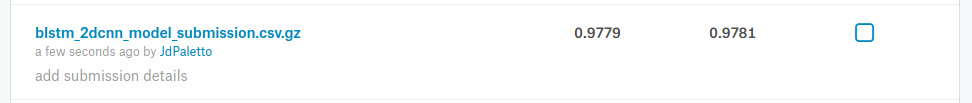

In [7]:
Image('benchmark_assets/blstm_2dcnn.png', width=1000)

### BGRU 2DCNN
Bidirectional GRU with 2 Dimensional Convolution and 2D Max Pooling

In [5]:
# import model
from models.gpu_model import bgru_2dcnn

# model
bgru_2dcnn_model = bgru_2dcnn(maxlen, max_features, embed_size, embedding_matrix,
                                embedding_dropout = .5,
                                bgru_units = 300,
                                bgru_dropout = .2,
                                cnn_filters = 100,
                                cnn_kernel_size = (5,5),
                                max_pool_size = (5,5),
                                dense_dropout = .4,
                                l2_reg = .00001,
                                gpus = gpus)

# fit
hist = bgru_2dcnn_model.fit(X_tra, y_tra, batch_size=32, epochs=3, validation_data=(X_val, y_val),
                 callbacks=[RocAuc], verbose=1)

Train on 143613 samples, validate on 15958 samples
Epoch 1/3
143613/143613 [==============================] - 506s 4ms/step - loss: 0.0622 - acc: 0.9798 - val_loss: 0.0580 - val_acc: 0.9810

 ROC-AUC - epoch: 1 - score: 0.982623 

Epoch 2/3
143613/143613 [==============================] - 502s 3ms/step - loss: 0.0509 - acc: 0.9835 - val_loss: 0.0529 - val_acc: 0.9835

 ROC-AUC - epoch: 2 - score: 0.986074 

Epoch 3/3
143613/143613 [==============================] - 502s 3ms/step - loss: 0.0453 - acc: 0.9855 - val_loss: 0.0626 - val_acc: 0.9810

 ROC-AUC - epoch: 3 - score: 0.986195 



In [7]:
# model
bgru_2dcnn_model = bgru_2dcnn(maxlen, max_features, embed_size, embedding_matrix,
                                embedding_dropout = .5,
                                bgru_units = 300,
                                bgru_dropout = .2,
                                cnn_filters = 100,
                                cnn_kernel_size = (5,5),
                                max_pool_size = (5,5),
                                dense_dropout = .4,
                                l2_reg = .00001,
                                gpus = gpus)

# fit on all data and save weights
hist = bgru_2dcnn_model.fit(x_train, y_train, batch_size=32, epochs=3, verbose=1)

# predict
y_pred = bgru_2dcnn_model.predict(x_test, batch_size=256, verbose=1)

# store
submission = pd.read_csv('../data/sample_submission.csv')
submission[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]] = y_pred
submission.to_csv('submissions/bgru_2dcnn_model_submission.csv.gz', compression='gzip', index=False)

Epoch 1/3
159571/159571 [==============================] - 549s 3ms/step - loss: 0.0611 - acc: 0.9801
Epoch 2/3
159571/159571 [==============================] - 548s 3ms/step - loss: 0.0516 - acc: 0.9833
Epoch 3/3
153164/153164 [==============================] - 31s 204us/step


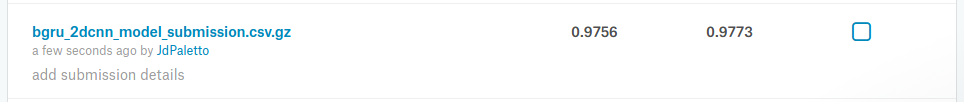

In [8]:
Image('benchmark_assets/bgru_2dcnn.png', width=1000)